In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json, os

In [2]:
models = [
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_m3d_M3dSegmentation/", "M3dNCA"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_OctreeNCASegmentation/", "OctreeNCA"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_efficientnet-b0_0_MinUNetSegmentation/", "UNet Efficientnet"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_mobilenet_v2_0_MinUNetSegmentation/", "UNet Mobilenetv2"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_resnet18_0_MinUNetSegmentation/", "UNet Resnet18"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_vgg11_0_MinUNetSegmentation/", "UNet VGG11"),
]

In [3]:
annnotation_list = []
all_files = []
for i, (model, model_name) in enumerate(models):
    score = pd.read_csv(f"{model}eval/standard.csv", sep='\t').loc[:, "DiceScore/0"].mean()

    mem_allocation = json.load(open(f"{model}/mem_allocation.json"))["byte"]
    num_params = json.load(open(f"{model}/num_params.json"))["num_params"]

    eval_file = {}

    eval_file["model"] = model
    eval_file["mem_allocation"] = mem_allocation
    eval_file["num_params"] = num_params
    eval_file["score"] = score
    df = pd.DataFrame(index=[i], data=eval_file)
    all_files.append(df)
    annnotation_list.append((num_params, score, model_name))

all_files = pd.concat(all_files)

In [4]:
def get_nnUNet_results(path: str, trainer: str) -> dict:
    FOLD = 0
    TRAIN_TASK = "Task506_Prostate_MEDSeg_split"
    EVAL_TASK = "Task508_Prostate_MEDSeg_split"

    eval_path = os.path.join(path,"evaluation", "nnUNet_ext", "3d_fullres",
                             TRAIN_TASK, TRAIN_TASK, f"{trainer}__nnUNetPlansv2.1", 
                             f"Generic_UNet/SEQ/head_None/fold_{FOLD}",EVAL_TASK,
                             "val_metrics_all.csv")
    
    results_path = os.path.join(path, "results", "nnUNet_ext", "3d_fullres",
                             TRAIN_TASK, TRAIN_TASK, f"{trainer}__nnUNetPlansv2.1", 
                             f"Generic_UNet/SEQ/fold_{FOLD}")

    results = pd.read_csv(eval_path, sep='\t')
    results = results[results["split"] == "test"]
    results = results[results["seg_mask"] == "mask_1"]
    results = results[results["metric"] == "Dice"]
    ret = {
        "model": trainer,
        "mem_allocation": json.load(open(os.path.join(results_path, "mem_allocation.json")))["byte"],
        "num_params": json.load(open(os.path.join(results_path, "num_params.json")))["num_params"],
        "score": results["value"].mean()
    }
    return ret

In [5]:
nnOctreeNCA = get_nnUNet_results("/local/scratch/clmn1/nnunet_nca", "nnUNetTrainerNCA")
nnUNet = get_nnUNet_results("/local/scratch/clmn1/nnunet_nca", "nnUNetTrainerSequential")
data = [nnOctreeNCA, nnUNet]
df = pd.DataFrame(index= [0,1], data=data)
all_files = pd.concat([all_files, df])
for model_d in data:
    annnotation_list.append((model_d["num_params"], model_d["score"], model_d["model"]))

Text(0.5, 1.0, 'Prostate segmentation')

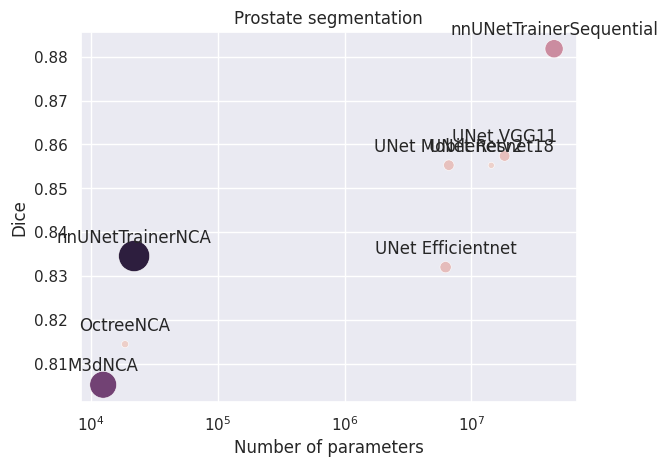

In [8]:
sns.set_theme()
ax = sns.scatterplot(data=all_files, x="num_params", y="score", hue="mem_allocation", size="mem_allocation",legend=False, sizes=(20, 500))
for x,y,txt in annnotation_list:
    ax.annotate(txt, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
plt.xscale("log")
plt.xlabel("Number of parameters")
plt.ylabel("Dice")
plt.title("Prostate segmentation")

In [7]:
annnotation_list

[(12480, 0.8051789658410209, 'M3dNCA'),
 (18560, 0.8144296748297555, 'OctreeNCA'),
 (6250893, 0.8319974882262093, 'UNet Efficientnet'),
 (6628369, 0.8552530322756086, 'UNet Mobilenetv2'),
 (14321937, 0.8552156261035374, 'UNet Resnet18'),
 (18252881, 0.8573561821665082, 'UNet VGG11'),
 (21888, 0.8345355537905039, 'nnUNetTrainerNCA'),
 (44797408, 0.8818071781343068, 'nnUNetTrainerSequential')]